In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns 
import matplotlib.pyplot as plt
import math

data_dir = "../data"
print(os.listdir(data_dir))

['.DS_Store', 'test_V2.csv', 'group_match_data_train_non_norm.zip', 'train_V2.csv', 'group_match_data_train_norm.zip']


# Data Analysis

In [5]:
df_train = pd.read_csv("../data/train_V2.csv")

In [254]:
# df_test = pd.read_csv("../data/test_V2.csv.zip")

In [255]:
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


## new player features

In [256]:
# heal and boosts
df_train['healsandboosts'] = df_train['heals'] + df_train['boosts']

In [257]:
# headshot rate
df_train['headshot_rate'] = df_train['headshotKills'] / df_train['kills']
df_train['headshot_rate'] = df_train['headshot_rate'].fillna(0)

In [258]:
# total distance
df_train['totalDistance'] = df_train['rideDistance'] + df_train['walkDistance'] + df_train['swimDistance']

In [259]:
# team_mode, 0 solo, 1 team
df_train['team_mode'] = df_train['matchType'].apply(lambda tp: 0 if tp in ['solo', 'solo-fpp'] else 1)

In [260]:
# df_train[['kills', 'damageDealt', 'assists']][0:100].apply(axis=1, func=lambda x: x['damageDealt'] / (x['kills'] + x['assists']) if (x['kills'] + x['assists']) > 0 else 0)
# df_train['damage_per_enemy'] = df_train[['kills', 'damageDealt', 'assists']].apply(axis=1, func=lambda x: x['damageDealt'] / (x['kills'] + x['assists']) if (x['kills'] + x['assists']) > 0 else 0)

# damage per enemy.
df_train['damage_per_enemy'] = df_train['damageDealt'] / (df_train['kills'] + df_train['assists'])
df_train['damage_per_enemy'] = df_train['damage_per_enemy'].fillna(0).apply(lambda x: 0 if x > 999999 else x)

In [261]:
# average walk kills
df_train['avg_walk_speed'] = df_train['walkDistance'] / df_train['matchDuration']

In [262]:
# count as 1 player
df_train['player_count'] = 1

1. player joined
2. weapon_acquire / total_distance

## outliers / cheaters

#### 1. remove wtf model

In [263]:
mts = ['solo','squad','duo','squad-fpp','duo-fpp','solo-fpp',]

In [264]:
len(df_train.query(f'matchType in {str(mts)}')) / len(df_train)

0.9920694244120598

In [265]:
df_train = df_train.query(f'matchType in {str(mts)}')

#### 2.remove matches with player amount less than 80

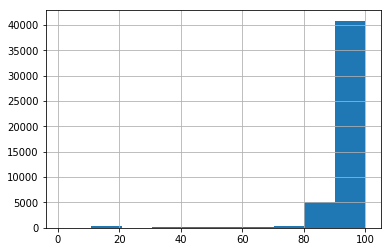

In [266]:
pd.value_counts(df_train['matchId']).hist()

In [1]:
match_players = pd.value_counts(df_train['matchId'])
df_train['match_plays'] = df_train['matchId'].apply(lambda x: match_players[x])
df_train = df_train.query('match_plays > 80')

NameError: name 'pd' is not defined

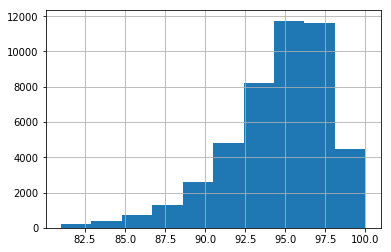

In [268]:
pd.value_counts(df_train['matchId']).hist()

#### 3.remove the abnormal winner

for solo mode, high rank with poor performance is abnormal

In [269]:
df_train.query('kills > 1 and totalDistance < 10 and team_mode == 0')\
.sort_values('winPlacePerc', ascending=False)[['winPlacePerc']]\
.quantile(0.99)

winPlacePerc    0.173102
Name: 0.99, dtype: float64

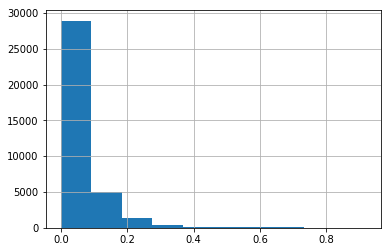

In [270]:
# df_train.query('totalDistance < 10 and kills < 1 and team_mode == 0 and winPlacePerc > 0.9')
# df_train.query('matchId == "ff60bfbccd8706"')[['kills', 'totalDistance', 'winPlacePerc']]\
# .sort_values('winPlacePerc', ascending=False).head(10)
df_train.query('totalDistance < 10 and kills < 1 and team_mode == 0')['winPlacePerc'].hist()

In [271]:
outlers_id = df_train.query('totalDistance < 10 and kills < 1 and team_mode == 0 and winPlacePerc > 0.3')['Id'].unique()

In [272]:
df_train = df_train.query(f"Id not in {str(outlers_id.tolist())}")

#### 4. abnormal features

In [291]:
abnormal_groups = set([])

avg_walk_speed > 6

In [294]:
abnormal_groups |= set(df_train.query('avg_walk_speed > 6')['groupId'].unique().tolist())

In [295]:
print(df_train['avg_walk_speed'].quantile(0.9999))
# df_train.drop(df_train[df_train['avg_walk_speed'] > 6].index, inplace=True)

5.0771133190754885


In [300]:
# weapons acquired > 80
print(df_train['weaponsAcquired'].quantile(0.9999))
# df_train.drop(df_train[df_train['weaponsAcquired'] >= 80].index, inplace=True)
abnormal_groups |= set(df_train.query('totalDistance == 0 and weaponsAcquired > 2')['groupId'].unique().tolist())

18.0


In [316]:
# heals > 45
# print(df_train['heals'].quantile(0.9999))
# df_train.drop(df_train[df_train['heals'] > 45].index, inplace=True)
# (df_train['heals'] * 3 / df_train['matchDuration']).quantile(1)

In [331]:
# longest kill > 1000
print(df_train['longestKill'].quantile(1))
# df_train.drop(df_train[df_train['longestKill'] >= 1000].index, inplace=True)
# df_train.query('longestKill > 1000')['longestKill'].hist()

1003.0


In [343]:
# road kill > 10
# print(df_train['roadKills'].quantile(0.999))
# df_train.drop(df_train[df_train['roadKills'] > 10].index, inplace=True)
# df_train.query('roadKills == 14')#['roadKills'].hist()

In [351]:
# headshot rate alwasy == 1 and always headshot
# df_train.drop(df_train.query('headshot_rate == 1 and kills > 9').index, inplace=True)
abnormal_groups |= set(df_train.query('headshot_rate == 1 and kills > 4 and damageDealt / kills % 100 == 0')['groupId'].unique().tolist())

In [354]:
# match duration
df_train['matchDuration'].quantile(0.000001)

972.0

In [358]:
# killStreaks > 8
abnormal_groups |= set(df_train.query('killStreaks > 8')['groupId'].unique().tolist())

In [361]:
# delete abnormal groups
df_train = df_train.query(f'groupId not in {str(list(abnormal_groups))}')

## Group by data by group & match 

In [393]:
agg_funcs = {'assists':'sum',
             'boosts':'sum',
             'damageDealt':'sum',
             'DBNOs':'sum',
             'headshotKills':'sum',
             'heals':'sum',
             'killPlace':'max',
             'killPoints':'sum',
             'kills':'sum',
             'killStreaks':'sum',
             'longestKill':'max',
             'matchDuration':'mean',
             'matchType':'max', # new value
             'maxPlace':'max', # may not equal to group num
             'numGroups':'max',
             'rankPoints':'sum', # depatured in next version
             'revives':'sum',
             'rideDistance':'max',
             'roadKills':'sum',
             'swimDistance':'max',
             'teamKills':'sum',
             'vehicleDestroys':'sum',
             'walkDistance':'max',
             'weaponsAcquired':'sum',
             'winPoints':'sum', # rankPoints where only win counts
             'winPlacePerc':'max', # 1 is best, 0 is last
             'healsandboosts':'max',
             'headshot_rate':'max',
             'totalDistance':'max',
             'team_mode':'max',
             'damage_per_enemy':'max',
             'avg_walk_speed':'max',
             'player_count':'sum'}

In [394]:
group_match_data = df_train.groupby(['groupId', 'matchId'])
group_match_data = group_match_data.agg(agg_funcs)
group_match_data = group_match_data.sort_values(by=['matchId','winPlacePerc'],
                                                ascending=False)
group_match_data = group_match_data.reset_index()
group_match_data = group_match_data.sort_values(by=['matchId', 'winPlacePerc'],
                                                ascending=False)
group_match_data = group_match_data.reindex()

#### onehot encoding

In [395]:
for col in group_match_data.columns:
    if 'matchType_onehot_' in col:
        group_match_data.drop(columns=col, axis=1, inplace=True)

In [400]:
group_match_data.columns

Index(['groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'healsandboosts',
       'headshot_rate', 'totalDistance', 'team_mode', 'damage_per_enemy',
       'avg_walk_speed', 'player_count', 'matchType_onehot_duo',
       'matchType_onehot_duo-fpp', 'matchType_onehot_solo',
       'matchType_onehot_solo-fpp', 'matchType_onehot_squad',
       'matchType_onehot_squad-fpp'],
      dtype='object')

In [397]:
group_match_data['matchType_onehot'] = group_match_data['matchType']
group_match_data = pd.get_dummies(group_match_data, columns=['matchType_onehot'])

## group outliers

In [398]:
group_match_data['matchType'].unique().tolist()

['squad-fpp', 'duo-fpp', 'solo-fpp', 'solo', 'squad', 'duo']

In [399]:
for mt in group_match_data['matchType'].unique().tolist():
    limit = 1
    if 'squad' in mt:
        limit = 5
    elif 'duo' in mt:
        limit = 2
    elif 'solo' in mt:
        limit = 1
    abnormal_amount = len(group_match_data.query(f'matchType == "{mt}" and player_count > {limit}')['groupId'].unique())
    all_amount = len(group_match_data.query(f'matchType == "{mt}"')['groupId'].unique())
    print(f"for {mt}, total groups: {all_amount}, abnormal groups: {abnormal_amount}, percentage: {round(abnormal_amount * 100 / all_amount, 2)}%")

for squad-fpp, total groups: 501681, abnormal groups: 41371, percentage: 8.25%
for duo-fpp, total groups: 482211, abnormal groups: 35932, percentage: 7.45%
for solo-fpp, total groups: 517630, abnormal groups: 11166, percentage: 2.16%
for solo, total groups: 163982, abnormal groups: 4725, percentage: 2.88%
for squad, total groups: 175571, abnormal groups: 17434, percentage: 9.93%
for duo, total groups: 150241, abnormal groups: 12711, percentage: 8.46%


In [401]:
len(group_match_data['matchId'].unique())

46036

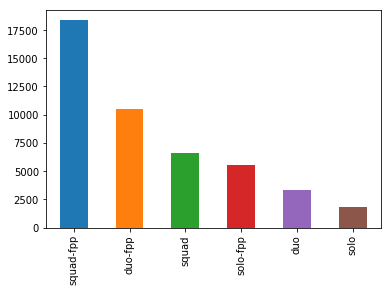

In [402]:
pd.value_counts(group_match_data.groupby('matchId').last()['matchType']).plot(kind='bar')

In [411]:
abnormal_groups |= set(group_match_data.query('(team_mode==0 and player_count > 1) or \
(matchType == "duo-fpp" and player_count > 2) or \
(matchType == "duo" and player_count > 2) or \
(matchType == "squad-fpp" and player_count > 5) or \
(matchType == "squad" and player_count > 5)')['groupId'].unique().tolist())

In [412]:
# delete abnormal groups
group_match_data = group_match_data.query(f'groupId not in {str(list(abnormal_groups))}')

In [413]:
# group_match_data.query('team_mode==0 and player_count > 1').sort_values('winPlacePerc', ascending=False)['winPlacePerc'].hist()
# group_match_data.query('matchType == "duo-fpp" and player_count > 2').sort_values('winPlacePerc', ascending=False)['winPlacePerc'].hist()
# group_match_data.query('matchType == "duo" and player_count > 2').sort_values('winPlacePerc', ascending=False)['winPlacePerc'].hist()
# group_match_data.query('matchType == "squad-fpp" and player_count > 5').sort_values('winPlacePerc', ascending=False)['winPlacePerc'].hist()
# group_match_data.query('matchType == "squad" and player_count > 5').sort_values('winPlacePerc', ascending=False)['winPlacePerc'].hist()
# group_match_data.query('matchId == "ff26a45f876a49"').sort_values(['winPlacePerc', 'groupId'], ascending=False)# and groupId == "c0019909c00573"')# and 
# group_match_data.query('matchType == "squad" and player_count > 15')# and winPlacePerc > 0.9')
# df_train.query('matchType == "fffe53015be300" and groupId == "07b6286649f1e5"')

In [415]:
len(group_match_data)

1867977

In [455]:
abnormal_groups |= set(group_match_data.query('totalDistance < 50 and kills < 1 and winPlacePerc > 0.8')['groupId'].unique().tolist())

In [456]:
# delete abnormal groups
group_match_data = group_match_data.query(f'groupId not in {str(list(abnormal_groups))}')

## new feature for group

*total distance for group*

In [464]:
match_max_distance = group_match_data.groupby('matchId')['totalDistance'].max().to_dict()
group_match_data['match_max_distance'] = group_match_data['matchId'].apply(lambda x: match_max_distance[x])
group_match_data['totalDistancePlace'] = group_match_data['totalDistance'] / group_match_data['match_max_distance']
group_match_data.drop('match_max_distance', axis=1, inplace=True)

In [471]:
group_match_data.head()

,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,damage_per_enemy,avg_walk_speed,player_count,matchType_onehot_duo,matchType_onehot_duo-fpp,matchType_onehot_solo,matchType_onehot_solo-fpp,matchType_onehot_squad,matchType_onehot_squad-fpp,totalDistancePlace
0,809d8288457e3d,fffe92232706aa,3,16,1196.30,8,3,13,21,0,...,181.25,1.452496,3,0,0,0,0,0,1,0.543120
1,6cfbeead9e1050,fffe92232706aa,2,9,1087.00,8,1,4,6,0,...,93.82,1.794954,2,0,0,0,0,0,1,0.541508
2,bd5b4ecf8067ab,fffe92232706aa,2,8,617.03,4,2,20,23,0,...,254.20,1.290392,3,0,0,0,0,0,1,0.771560
3,20493abb7ca1b9,fffe92232706aa,3,4,897.10,6,2,4,38,0,...,97.72,1.320988,3,0,0,0,0,0,1,0.410593
4,1958cde581220c,fffe92232706aa,2,12,308.97,1,0,14,39,0,...,114.80,1.575953,3,0,0,0,0,0,1,1.000000


In [475]:
group_match_data.columns

Index(['groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'healsandboosts',
       'headshot_rate', 'totalDistance', 'team_mode', 'damage_per_enemy',
       'avg_walk_speed', 'player_count', 'matchType_onehot_duo',
       'matchType_onehot_duo-fpp', 'matchType_onehot_solo',
       'matchType_onehot_solo-fpp', 'matchType_onehot_squad',
       'matchType_onehot_squad-fpp', 'totalDistancePlace'],
      dtype='object')

## Drop column

In [ ]:
# ['winPoints', 'killPoints', '']

## load backup data

In [506]:
del group_match_data_org

In [588]:
group_match_data = pd.read_csv(os.path.join(data_dir,'group_match_data_train_non_norm.zip'))

In [589]:
group_match_data_org = group_match_data.copy()

In [571]:
group_match_data = group_match_data_org

## normalization

In [602]:
# MinMaxScaler
norm_attrs = ['kills', 'assists', 'DBNOs', 'revives', 'heals', 'boosts']

In [603]:
for attr in norm_attrs:
    print(f'processing {attr}...')
    match_max_attr = group_match_data.groupby('matchId')[f'{attr}'].max().to_dict()
    group_match_data['match_max_attr'] = group_match_data['matchId'].apply(lambda x: match_max_attr[x] if match_max_attr[x] > 0 else 1)
    group_match_data[f'{attr}'] = group_match_data[f'{attr}'] / group_match_data['match_max_attr']
    group_match_data.drop('match_max_attr', axis=1, inplace=True)
    print(f'processing {attr} done...')

processing kills...
processing kills done...
processing assists...
processing assists done...
processing DBNOs...
processing DBNOs done...
processing revives...
processing revives done...
processing heals...
processing heals done...
processing boosts...
processing boosts done...


In [604]:
len(group_match_data[norm_attrs].dropna())

1867964

In [605]:
len(group_match_data)

1867964

## standardlization

In [597]:
# StandardScale
# (v - mean) / std
stand_attrs = ['killStreaks', 'damageDealt', 'swimDistance', 'rideDistance', 'walkDistance']

In [598]:
for attr in stand_attrs:
    print(f'processing {attr}...')
    match_mean_attr = group_match_data.groupby('matchId')[f'{attr}'].mean().to_dict()
    match_std_attr = group_match_data.groupby('matchId')[f'{attr}'].std().to_dict()
    group_match_data['match_mean_attr'] = group_match_data['matchId'].apply(lambda x: match_mean_attr[x])
    group_match_data['match_std_attr'] = group_match_data['matchId'].apply(lambda x: match_std_attr[x] if match_std_attr[x] > 0 else 1)
    group_match_data[f'{attr}'] = (group_match_data[f'{attr}'] - group_match_data['match_mean_attr'])/ group_match_data['match_std_attr']
    group_match_data.drop('match_mean_attr', axis=1, inplace=True)
    group_match_data.drop('match_std_attr', axis=1, inplace=True)
    print(f'processing {attr} done...')

processing killStreaks...
processing killStreaks done...
processing damageDealt...
processing damageDealt done...
processing swimDistance...
processing swimDistance done...
processing rideDistance...
processing rideDistance done...
processing walkDistance...
processing walkDistance done...


In [606]:
len(group_match_data[['swimDistance', 'rideDistance']].dropna())

1867964

In [599]:
len(group_match_data[stand_attrs].dropna())

1867964

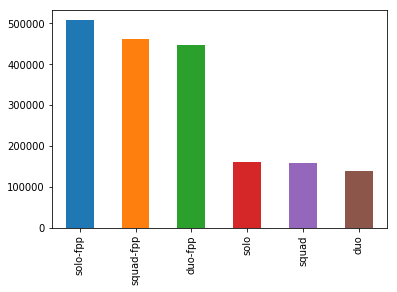

In [496]:
pd.value_counts(group_match_data['matchType']).plot(kind='bar')

~~**rename groupId & matchId**~~

In [162]:
# # np.array(range(len(group_match_data['groupId'])))
# group_match_data['groupId'] = np.arange(len(group_match_data['groupId']))

# reindex_match_dict = dict()
# counter = 0
# for matchId in group_match_data.matchId.values:
#     if matchId not in reindex_match_dict:
#         reindex_match_dict[matchId] = counter
#         counter += 1

# group_match_data['matchId'] = \
# group_match_data['matchId'].apply(lambda x: reindex_match_dict[x])

# del reindex_match_dict

**save group match data. because groupby is very slow.**

In [609]:
group_match_data.to_csv(os.path.join(data_dir,'group_match_data_train_norm.zip'), 
                        index=False, sep=',', quotechar='"', compression='zip')

## 1.1 load team & match data directly from saved file.

In [27]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns 
import matplotlib.pyplot as plt
import math

data_dir = "../data"
print(os.listdir(data_dir))

['group_match_data_train.zip', 'test_V2.csv.zip', 'train_V2.csv.zip']


In [28]:
group_match_data = \
pd.read_csv(os.path.join(data_dir,'group_match_data_train.zip'))

## 2. analysis team & match data

In [190]:
pd.value_counts(group_match_data['matchType'])
# matchtp = group_match_data['matchType']

solo-fpp     517619
squad-fpp    501714
duo-fpp      482233
squad        175585
solo         164001
duo          150248
Name: matchType, dtype: int64

In [191]:
import seaborn as sns

Text(0, 0.5, 'Data Size')

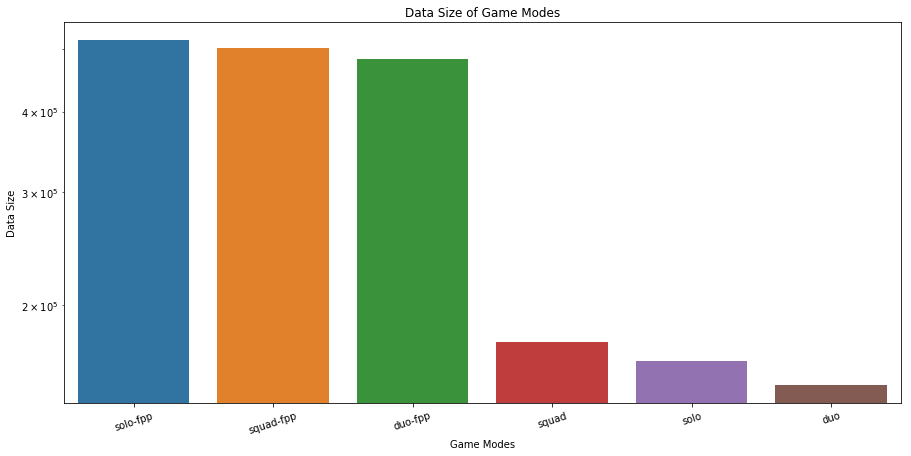

In [192]:
fig = plt.figure(figsize=(15,7))
data_plt = pd.value_counts(group_match_data['matchType'])
ind = data_plt.keys().tolist()
l_0 = data_plt
p1 = sns.barplot(ind, l_0, log=True)
plt.xticks(rotation=18)
plt.title('Data Size of Game Modes')
plt.xlabel('Game Modes')
plt.ylabel('Data Size')
# .plot(kind='bar', log=True, figsize=(15,7), xrotation=15)

In [196]:
corr = group_match_data.corr()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


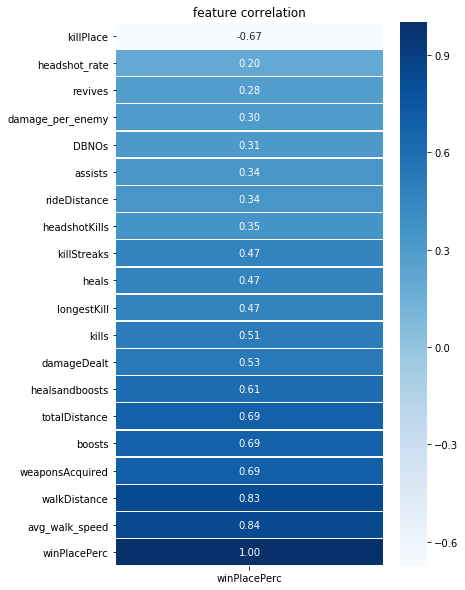

In [197]:
# corr= df_train.corr()
Y_Column = 'winPlacePerc'
corr_Target = corr[[Y_Column]]
x = 0.2
corr_T= corr_Target[abs(corr_Target['winPlacePerc'])>x]
corr_T = corr_T.sort_values(by='winPlacePerc')
fig = plt.figure(figsize=(6, 10))
# f,ax = plt.subplots()
sns.heatmap(corr_T, annot=True, linewidths=.5, fmt= '.2f', cmap=plt.cm.Blues)
plt.title("feature correlation",fontsize=12)
fig.show()
# fig.savefig("corr_2_winPlace.png")